In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from matplotlib import pyplot as plt
from counterfactuals.cf_methods.ppcef import PPCEF
from counterfactuals.datasets import MoonsDataset
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import MultilayerPerceptron
from counterfactuals.losses import BinaryDiscLoss
from counterfactuals.metrics import evaluate_cf

ModuleNotFoundError: No module named 'counterfactuals'

In [3]:
dataset = MoonsDataset("../data/moons.csv")
train_dataloader = dataset.train_dataloader(batch_size=1024, shuffle=True)
test_dataloader = dataset.test_dataloader(batch_size=1024, shuffle=False)

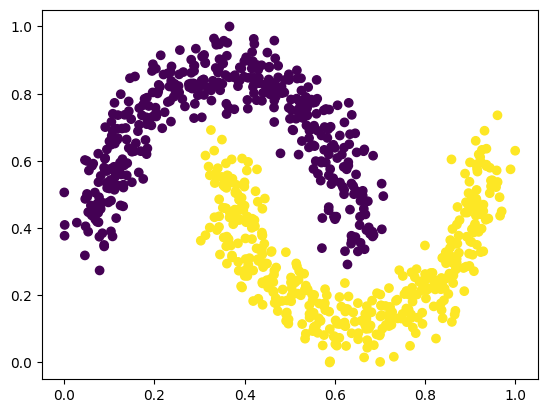

In [4]:
for X, y in train_dataloader:
    plt.scatter(X[:, 0], X[:, 1], c=y)

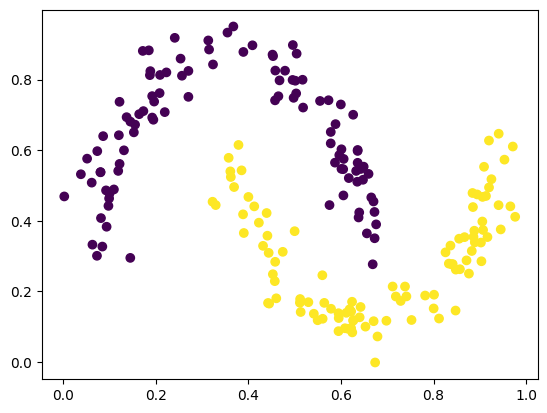

In [5]:
for X, y in test_dataloader:
    plt.scatter(X[:, 0], X[:, 1], c=y)

In [33]:
train_dataloader = dataset.train_dataloader(batch_size=128, shuffle=True)
test_dataloader = dataset.test_dataloader(batch_size=128, shuffle=False)
disc_model = MultilayerPerceptron(
    input_size=2, hidden_layer_sizes=[256, 256], target_size=1, dropout=0.2
)
disc_model.fit(
    train_dataloader,
    test_dataloader,
    epochs=5000,
    patience=300,
    lr=1e-3,
)
# disc_model.load("../models/MoonsDataset/disc_model_MultilayerPerceptron.pt")

Epoch 1029, Train: 0.0447, test: 0.0389, patience: 300:  21%|██        | 1030/5000 [00:22<01:26, 45.64it/s]


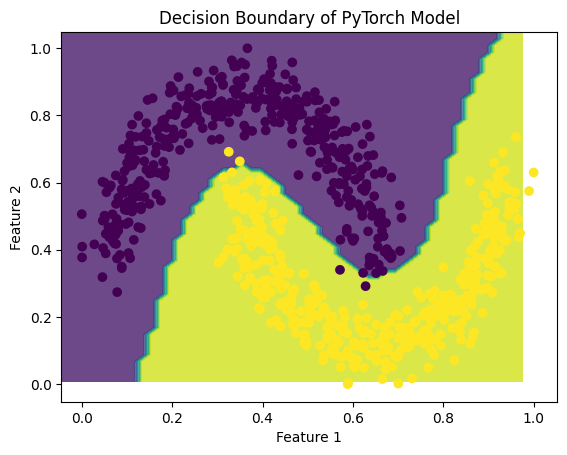

In [34]:
import numpy as np

# Create a mesh grid for plotting decision boundaries
h = 0.02
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Make predictions on the grid points
disc_model.eval()
with torch.no_grad():
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    Z = disc_model.predict(grid_points)
    Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", s=20)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision Boundary of PyTorch Model")

for X, y in train_dataloader:
    plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [35]:
gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_train.shape[1], hidden_features=8, context_features=1
)
gen_train_dataloader = dataset.train_dataloader(
    batch_size=1024, shuffle=True, noise_lvl=0.03
)
gen_model.fit(train_dataloader, test_dataloader, num_epochs=1000)

Epoch 286, Train: -1.4404, test: -1.4309, patience: 20:  29%|██▊       | 286/1000 [00:17<00:43, 16.46it/s]
/Users/ofurman/Study/counterfactuals/counterfactuals/generative_models/maf.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on

In [37]:
cf = PPCEF(
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=BinaryDiscLoss(),
    neptune_run=None,
)
cf_dataloader = dataset.test_dataloader(batch_size=1024, shuffle=False)
log_prob_threshold = torch.quantile(gen_model.predict_log_prob(cf_dataloader), 0.25)
deltas, X_orig, y_orig, y_target, logs = cf.explain_dataloader(
    cf_dataloader, alpha=100, log_prob_threshold=log_prob_threshold, epochs=4000
)

tensor(1.2127)


Discriminator loss: 0.0000, Prob loss: 0.0000:  68%|██████▊   | 2702/4000 [00:12<00:05, 218.36it/s]


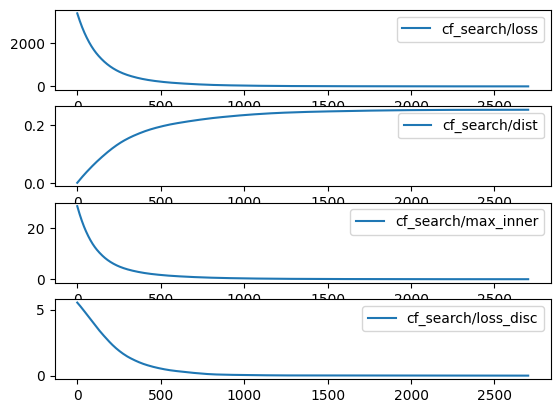

In [39]:
for i, (log_name, log_vals) in enumerate(logs.items()):
    plt.subplot(len(logs), 1, i + 1)
    plt.plot(log_vals, label=log_name)
    plt.legend()

In [40]:
X_cf = X_orig + deltas

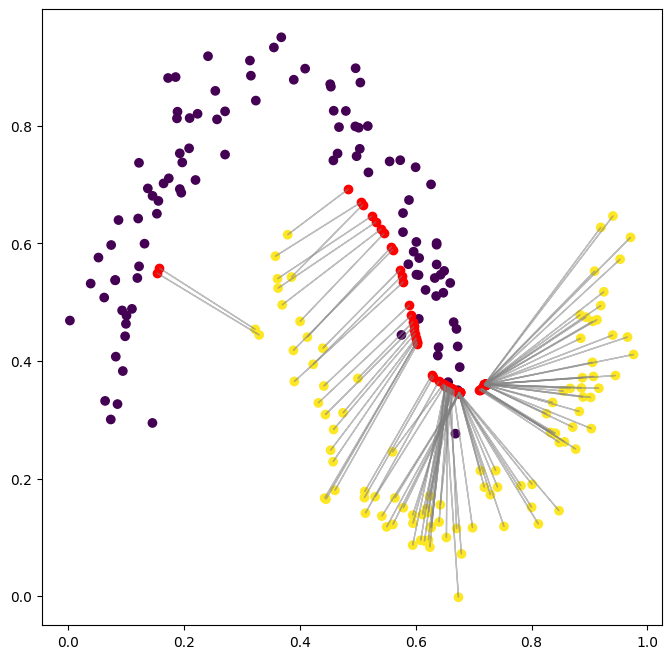

In [41]:
fig, ax = plt.subplots(figsize=(8, 8))

i = y_orig.reshape(-1) == 1
ax.scatter(X_orig[:, 0], X_orig[:, 1], c=y_orig)
ax.scatter(X_orig[i, 0] + deltas[i, 0], X_orig[i, 1] + deltas[i, 1], c="r")
for before, after in zip(X_orig[i], X_cf[i]):
    ax.arrow(
        before[0],
        before[1],
        after[0] - before[0],
        after[1] - before[1],
        head_width=0.0,
        head_length=0.0,
        fc="gray",
        ec="gray",
        alpha=0.5,
        width=0.0001,
    )

In [86]:
evaluate_cf(
    disc_model=disc_model,
    gen_model=gen_model,
    X_cf=X_cf,
    model_returned=np.ones(X_cf.shape[0]),
    continuous_features=dataset.numerical_features,
    categorical_features=dataset.categorical_features,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_orig,
    y_test=y_orig,
    median_log_prob=log_prob_threshold,
    y_target=y_target,
)

torch.FloatTensor
torch.FloatTensor


{'coverage': 1.0,
 'validity': 0.9853658536585366,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': nan,
 'proximity_categorical_jaccard': 0.2542709107751323,
 'proximity_continuous_manhattan': 0.3294058578955655,
 'proximity_continuous_euclidean': 0.2542709107751323,
 'proximity_continuous_mad': 1.6941933094865025,
 'proximity_l2_jaccard': 0.2542709107751323,
 'proximity_mad_hamming': nan,
 'prob_plausibility': 0.9951219512195122,
 'log_density_cf': 1.2318945,
 'log_density_test': -27.206976,
 'lof_scores_cf': 1.0578489,
 'lof_scores_test': 1.0409402,
 'isolation_forest_scores_cf': 0.028632471682979128,
 'isolation_forest_scores_test': 0.0041604418163049064}